## The goal of this notebook is to explore possible cremaster's scores

In [2]:
# Access the whole dataset and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

glucose_df = pd.read_csv('glucose.csv')
phases_df = pd.read_csv('hormones_and_selfreport.csv')

In [3]:

glucose_df.loc[glucose_df['glucose_value'] > 15, 'glucose_value'] *= 0.05556  # convert mg/dL to mmol/L
glucose_df[glucose_df['glucose_value'] > 15 ]

glist = (glucose_df
         .groupby(["id", "study_interval", "day_in_study"], as_index=False)
         .agg(glucose_values=("glucose_value", list))
        )

glist["glucose_times"] = (glucose_df
    .groupby(["id", "study_interval", "day_in_study"])["timestamp"]
    .agg(list)
    .values
)

combined = phases_df.merge(
    glist,
    on=["id", "study_interval", "day_in_study"],
    how="left"
)


In [4]:
long_df = combined.explode(['glucose_times', 'glucose_values']).reset_index(drop=True)
long_df["glucose_values"] = pd.to_numeric(long_df["glucose_values"], errors="coerce")

simple_df = long_df[['id', 'day_in_study', 'phase', 'glucose_values', 'glucose_times']].copy()
simple_df.head(10)


,id,day_in_study,phase,glucose_values,glucose_times
0,1,1,Follicular,4.9,00:04:06
1,1,1,Follicular,5.0,00:09:06
2,1,1,Follicular,5.1,00:14:07
3,1,1,Follicular,5.1,00:19:06
4,1,1,Follicular,5.1,00:24:06
5,1,1,Follicular,5.2,00:29:06
6,1,1,Follicular,5.3,00:34:07
7,1,1,Follicular,5.3,00:39:07
8,1,1,Follicular,5.3,00:44:07
9,1,1,Follicular,4.9,00:49:06


In [5]:
# Now bin glucose by averaging glucose over every hour for each individual. Keep phase data and day in study
# bin glucose by hour for each individual
simple_df['glucose_times'] = pd.to_datetime(simple_df['glucose_times'], format='%H:%M:%S', errors='coerce')
simple_df['1_hr_idx'] = simple_df['glucose_times'].dt.hour
hourly_avg = (simple_df
              .groupby(['id', 'day_in_study', 'phase', '1_hr_idx'], as_index=False)
              .agg(hourly_glucose_avg=('glucose_values', 'mean'))
             )

hourly_avg.head(10)

,id,day_in_study,phase,1_hr_idx,hourly_glucose_avg
0,1,1,Follicular,0.0,5.116667
1,1,1,Follicular,1.0,5.475000
2,1,1,Follicular,2.0,5.225000
3,1,1,Follicular,3.0,5.475000
4,1,1,Follicular,4.0,5.200000
5,1,1,Follicular,5.0,5.283333
6,1,1,Follicular,6.0,5.691667
7,1,1,Follicular,7.0,5.475000
8,1,1,Follicular,8.0,5.458333
9,1,1,Follicular,9.0,5.583333



First 3 Individuals:


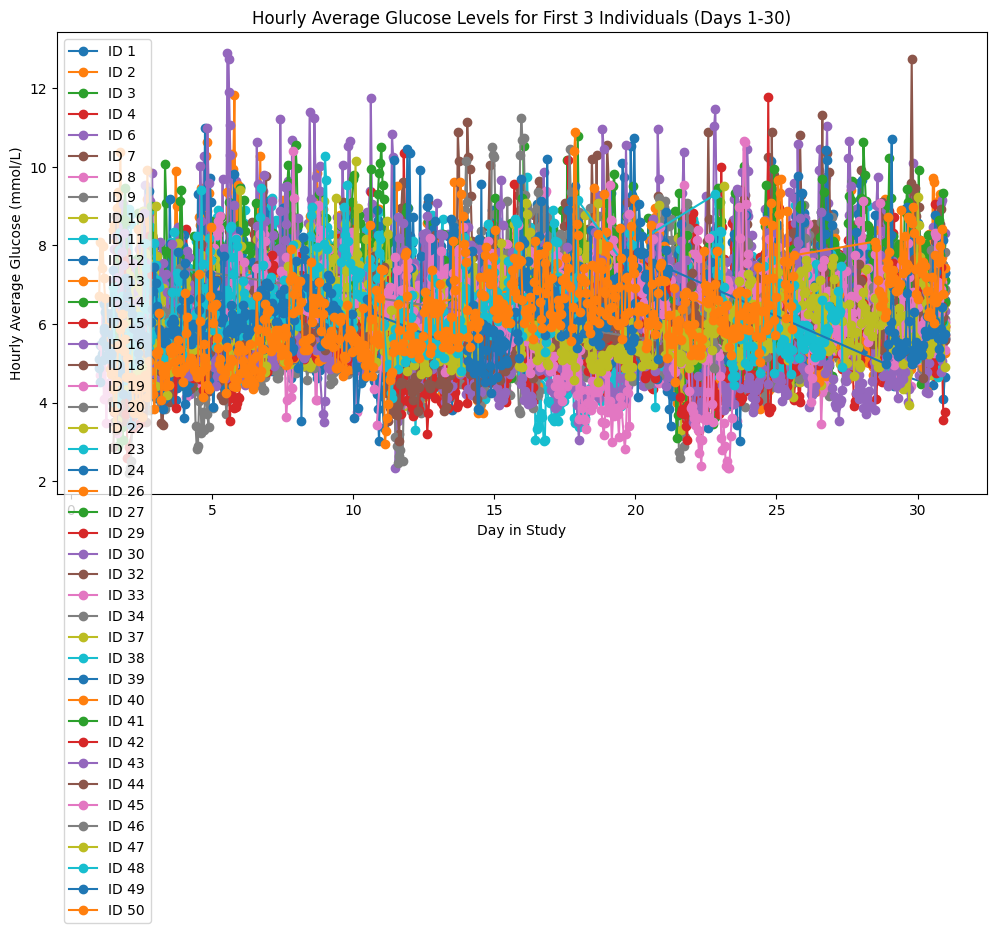

In [6]:
# select first 3 indivudals

#first3 = hourly_avg[hourly_avg['id'].isin(hourly_avg['id'].unique()[:3])].copy()
first3 = hourly_avg
print("\nFirst 3 Individuals:")
# only include first 30 days
first3 = first3[first3['day_in_study'] <= 30]

# plot all data for the first individuals for days 1 to 30
plt.figure(figsize=(12, 6))
for pid in first3['id'].unique():
    pdata = first3[first3['id'] == pid]
    plt.plot(pdata['day_in_study'] + pdata['1_hr_idx']/24, pdata['hourly_glucose_avg'], marker='o', label=f'ID {pid}')
plt.xlabel('Day in Study')
plt.ylabel('Hourly Average Glucose (mmol/L)')
plt.title('Hourly Average Glucose Levels for First 3 Individuals (Days 1-30)')
plt.legend()
plt.show()

# Include some imputation steps

In [7]:
# Impute using simple linear imputation for missing hourly averages
imputed_simple3 = first3.interpolate(method='linear', limit_direction='both')
# Now setup 3-hour average bins
imputed_simple3['3_hr_idx'] = imputed_simple3['1_hr_idx'] // 3
three_hr_avg = (imputed_simple3
                .groupby(['id', 'day_in_study', '3_hr_idx'])
                .agg({'hourly_glucose_avg': 'mean'})
                .reset_index())
# Now setup delta graph using a sliding window
# Calculate the delta (change) in glucose levels over a 3-hour sliding window with 1-hour timesteps
# Write a function to do this
def calculate_sliding_window_delta(df, window_size=3, step_size=1):
    deltas = []
    for pid in df['id'].unique():
        pdata = df[df['id'] == pid].sort_values(by=['day_in_study', '3_hr_idx'])
        for day in pdata['day_in_study'].unique():
            ddata = pdata[pdata['day_in_study'] == day]
            glucose_values = ddata['hourly_glucose_avg'].values
            for start in range(0, len(glucose_values) - window_size + 1, step_size):
                end = start + window_size
                delta = glucose_values[end - 1] - glucose_values[start]
                deltas.append({
                    'id': pid,
                    'day_in_study': day,
                    'start_idx': start,
                    'end_idx': end - 1,
                    'glucose_delta': delta
                })
    return pd.DataFrame(deltas)

# Now calculate on imputed simple 3
delta_df = calculate_sliding_window_delta(three_hr_avg, window_size=3, step_size=1)



C:\Users\carlo\AppData\Local\Temp\ipykernel_22856\2092789392.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  imputed_simple3 = first3.interpolate(method='linear', limit_direction='both')


- Factor (x)
- Jitter (rapid rate of change throughout the day)
- Rate of increase POST-meal
    - We snip to times where blood glucose is going up consistently (define some criteria for probably post-prand


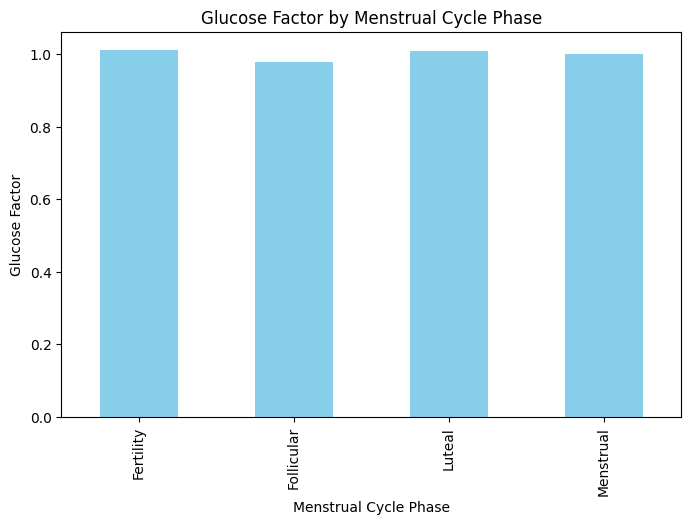

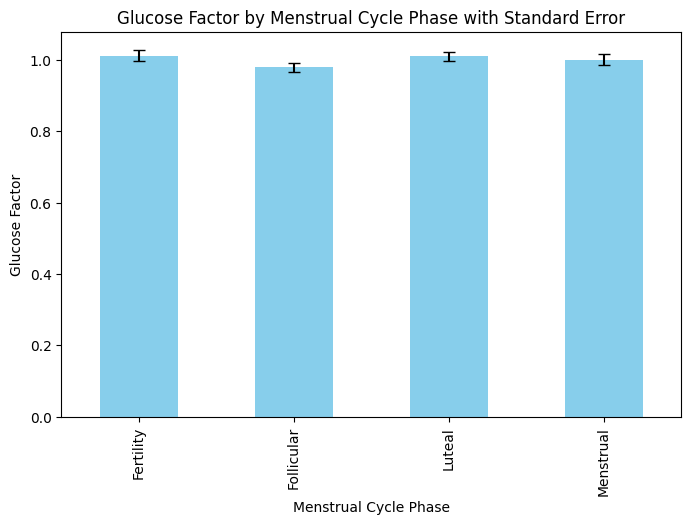

In [8]:
# Factor (x): This modeling method explores how we could use a factor to capture variability in baseline glucose levels across phases of menstrual cycle
# How? This method just takes an average and then calculates a factor for each phase
phase_means = imputed_simple3.groupby('phase')['hourly_glucose_avg'].mean()
phase_factors = phase_means / phase_means.mean()
# Now plot the phase factors
plt.figure(figsize=(8, 5))
phase_factors.plot(kind='bar', color='skyblue')
plt.xlabel('Menstrual Cycle Phase')
plt.ylabel('Glucose Factor')
plt.title('Glucose Factor by Menstrual Cycle Phase')
plt.show()

# Replot with error bars and a legend that shows standard deviation
# phase_std = imputed_simple3.groupby('phase')['hourly_glucose_avg'].std()
# plt.figure(figsize=(8, 5))
# phase_factors.plot(kind='bar', yerr=phase_std, capsize=4, color='skyblue', legend=True)
# plt.xlabel('Menstrual Cycle Phase')
# plt.ylabel('Glucose Factor')
# plt.title('Glucose Factor by Menstrual Cycle Phase with Standard Deviation')
# plt.show()

# Replot with errors bars that use standard error of the mean
phase_sem = imputed_simple3.groupby('phase')['hourly_glucose_avg'].sem()
plt.figure(figsize=(8, 5))
phase_factors.plot(kind='bar', yerr=phase_sem, capsize=4, color='skyblue')
plt.xlabel('Menstrual Cycle Phase')
plt.ylabel('Glucose Factor')
plt.title('Glucose Factor by Menstrual Cycle Phase with Standard Error')
plt.show()

# We would then 

In [ ]:
# Now, let's pretend this factor is a useful scale to adjust glucose readings based on menstrual cycle phase
# Now, let's predict glucose using this factor, and the rest of the data from the fitbit. 

# fitbit data
fitbit_csvs = ['heart_rate_variability_details.csv', 'estimated_oxygen_variation.csv']
# Extract all fitbit csvs and merge into a single dataframe
# Assume the csvs have different shapes but share 'id' and 'timestamp' columns




fitbit_dfs = []
for csv in fitbit_csvs:
    df = pd.read_csv(csv)
    fitbit_dfs.append(df)
from functools import reduce
fitbit_data = reduce(lambda left, right: pd.merge(left, right, on=['id', 'timestamp'], how='outer'), fitbit_dfs)
fitbit_data['timestamp'] = pd.to_datetime(fitbit_data['timestamp'], errors='coerce')

fitbit_data.head(10)


KeyError: 'timestamp'